<a href="https://colab.research.google.com/github/katrina906/CS6120-Summarization-Project/blob/main/exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%%capture
#!pip install -U seaborn

In [1]:
import os
import pandas as pd
import pickle
from nltk import tokenize
import string
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow
import nltk

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Load Data

In [5]:
df = pd.read_pickle("/content/drive/MyDrive/data/stories_df.pkl")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Extract Text Elements

In [6]:
def extract_summary(df):
    # find first instance of @highlight in text
    df['first_pos'] = df.text.str.find('@highlight')
    # new column for summary
    df['summary'] = df.apply(lambda row: row.text[row.first_pos:], axis = 1)
    df.summary = df.summary.str.replace('@highlight', '')
    # remove summary from text
    df.text = df.apply(lambda row: row.text[:row.first_pos], axis = 1)
    
    return df

def extract_words(df, source_var, word_var):
    df[word_var] = df[source_var].str.lower()
    df[word_var] = df[word_var].apply(lambda row: row.translate(str.maketrans('', '', string.punctuation)))
    df[word_var] = df[word_var].str.split(' ')
    
    return df

In [ ]:
# extract summary from text block
df = extract_summary(df)
df.summary = df.summary.str.strip()

# drop empty text (about 100 articles that only have summaries)
df = df[df.text != '  ']

# get sentences
# summary: @highlight chunks not separated by punctuation, so split by spaces and then within split by sentences
df['sentences_summary'] = df.summary.str.split('    ')
df.sentences_summary = df.sentences_summary.apply(lambda row: [tokenize.sent_tokenize(i) for i in row])
df.sentences_summary = df.sentences_summary.apply(lambda row: [item for sublist in row for item in sublist])
# text sentence tokenization using nltk
df['sentences'] = df.text.apply(lambda row: tokenize.sent_tokenize(row))

# strip location and news source designations off of first sentence
df['first_sentence'] = df.sentences.apply(lambda row: row[0])
df.first_sentence = df.first_sentence.str.split(' -- ').str[-1] \
                                     .str.replace('\\(CNN\\)', '')
df.sentences = df.apply(lambda row: [row.first_sentence] + row.sentences[1:], axis = 1)

# get words without punctuation, downcased for EDA
df = extract_words(df, 'text', 'words')
df = extract_words(df, 'summary', 'words_summary')

In [12]:
df.to_pickle("/content/drive/MyDrive/data/cleaned_df.pkl")

In [ ]:
#df = pd.read_pickle("/content/drive/MyDrive/data/cleaned_df.pkl")

### Distribution of Number of Sentences, Words

In [ ]:
df['num_sentences'] = df.sentences.apply(lambda row: len(row))
df['num_words'] = df.words.apply(lambda row: len(row))

df['num_sentences_summary'] = df.sentences_summary.apply(lambda row: len(row))
df['num_words_summary'] = df.words_summary.apply(lambda row: len(row))

__Text__

[Text(0.5, 0, 'Number of Sentences'), Text(0.5, 1.0, 'Article Distributions')]

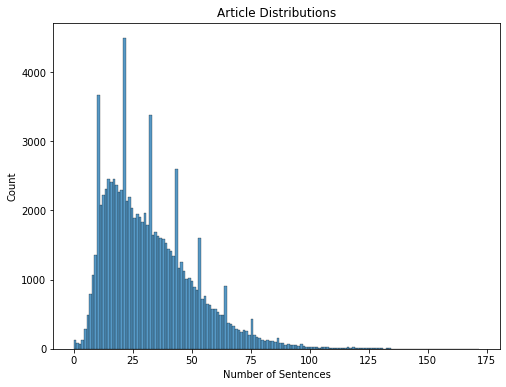

In [ ]:
plt.subplots(figsize = (8,6))
ax = sns.histplot(data = df, x = 'num_sentences')
ax.set(xlabel ='Number of Sentences', title = 'Article Distributions')

[Text(0.5, 0, 'Number of Words'), Text(0.5, 1.0, 'Article Distributions')]

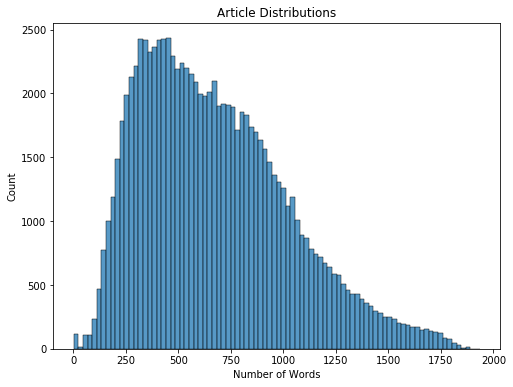

In [ ]:
plt.subplots(figsize = (8,6))
ax = sns.histplot(data = df, x = 'num_words')
ax.set(xlabel ='Number of Words', title = 'Article Distributions')

__Summary__

[Text(0.5, 0, 'Number of Words'), Text(0.5, 1.0, 'Summary Distributions')]

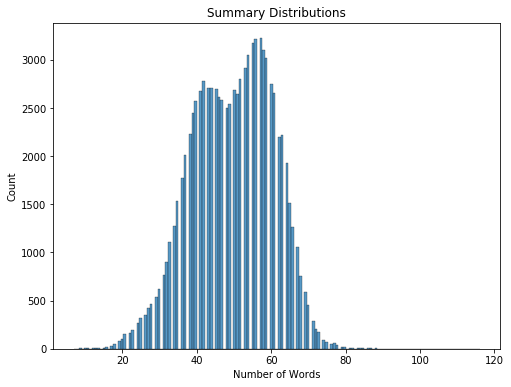

In [ ]:
plt.subplots(figsize = (8,6))
ax = sns.histplot(data = df, x = 'num_words_summary')
ax.set(xlabel ='Number of Words', title = 'Summary Distributions')

[Text(0.5, 0, 'Number of Sentences'), Text(0.5, 1.0, 'Summary Distributions')]

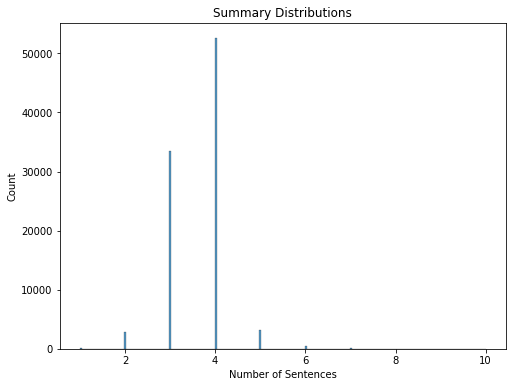

In [ ]:
plt.subplots(figsize = (8,6))
ax = sns.histplot(data = df, x = 'num_sentences_summary')
ax.set(xlabel ='Number of Sentences', title = 'Summary Distributions')

### Number of Words in Summary that don't appear in original text
Evidence for generative summarization - example summaries include words that are not in the main text

In [ ]:
def set_diff_words(row):
    return set(row.words_summary).difference(set(row.words))

df['new_summary_words'] = df.apply(lambda row: set_diff_words(row), axis = 1)
df['num_new_summary_words'] = df.new_summary_words.apply(lambda row: len(row))

[Text(0.5, 0, 'Number of Words'),
 Text(0.5, 1.0, 'Number of New Words in Summary')]

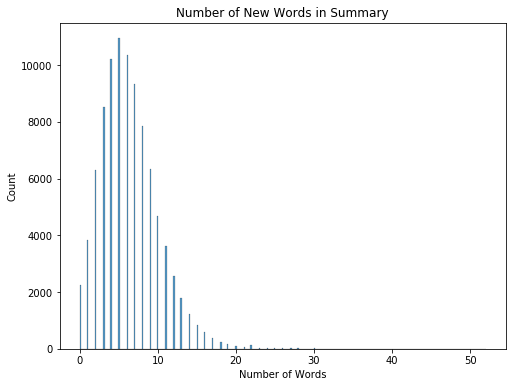

In [ ]:
plt.subplots(figsize = (8,6))
ax = sns.histplot(data = df, x = 'num_new_summary_words')
ax.set(xlabel ='Number of Words', title = 'Number of New Words in Summary')

__Percent of words that are new in summary__ 
(out of number of unique words)

In [ ]:
df['num_unique_words'] = df.apply(lambda row: len(set(row.words_summary)), axis = 1)
df['perc_new_words'] = df.num_new_summary_words / df.num_unique_words

[Text(0.5, 0, 'Percent of Words'),
 Text(0.5, 1.0, 'Percent of Words that are New in Summary')]

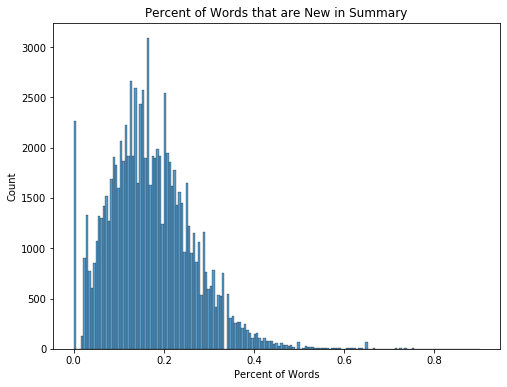

In [ ]:
plt.subplots(figsize = (8,6))
ax = sns.histplot(data = df, x = 'perc_new_words')
ax.set(xlabel ='Percent of Words', title = 'Percent of Words that are New in Summary')

## How long should the summary be? 

__Correlation between text and summary length__ 
- Positive correlation but not very strong

In [ ]:
df[['num_sentences', 'num_sentences_summary']].corr()

,num_sentences,num_sentences_summary
num_sentences,1.000000,0.203568
num_sentences_summary,0.203568,1.000000


In [ ]:
df[['num_words', 'num_words_summary']].corr()

,num_words,num_words_summary
num_words,1.000000,0.269358
num_words_summary,0.269358,1.000000


__Number of Summary Sentences per Text Sentences__
- About 6 text sentences per summary sentence
- Outliers > 1 because text is not naturally in sentences (ex listing soccer game scores)

In [ ]:
df['sentence_ratio'] = df.num_sentences_summary / df.num_sentences
df.sentence_ratio.describe()

count    92465.000000
mean         0.155073
std          0.111187
min          0.013514
25%          0.085106
50%          0.125000
75%          0.200000
max          4.000000
Name: sentence_ratio, dtype: float64

[Text(0.5, 0, '# Summary / # Text Sentences'),
 Text(0.5, 1.0, 'How many summary sentences per text sentence?')]

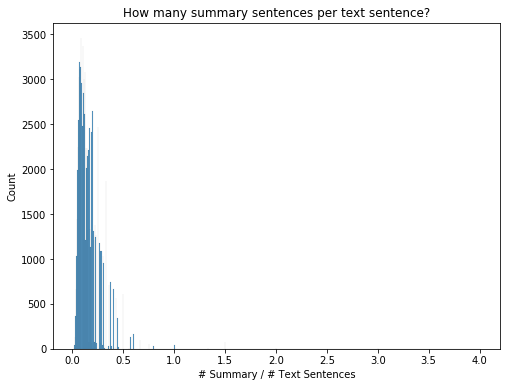

In [ ]:
plt.subplots(figsize = (8,6))
ax = sns.histplot(data = df, x = 'sentence_ratio')
ax.set(xlabel ='# Summary / # Text Sentences', title = 'How many summary sentences per text sentence?')